Contrastive Loss


In [ ]:

import os
import random
import ast


import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             matthews_corrcoef, precision_score, recall_score)
from itertools import chain
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm


torch.multiprocessing.set_sharing_strategy('file_system')





def set_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)



device = torch.device("cpu")


class EmbeddingNet(nn.Module):

    def __init__(self, input_size, d_model=64, nhead=2, dim_feedforward=32, dropout=0.43547725274485294, num_layers=1):

        super(EmbeddingNet, self).__init__()

        self.linear1 = nn.Linear(input_size, d_model)

        

        self.layernorm1 = nn.LayerNorm(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)

        self.linear2 = nn.Linear(d_model, d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def get_output_dim(self):

        
        return self.linear2.out_features

    def forward(self, x):

        x = self.linear1(x)
        x = self.layernorm1(x)
        x = self.transformer_encoder(x)
        x = self.linear2(x)
        x = self.layernorm2(x)

        return x


weight_decay = 1e-5
input_size = 58
d_model = 128
nhead = 16  


dim_feedforward = 256  
num_layers = 1
dropout = 0.2  
lr = 0.0001


class SiameseNetwork(nn.Module):

    def __init__(self, input_size, d_model, nhead, dim_feedforward, dropout, num_layers):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = EmbeddingNet(
            input_size, d_model, nhead, dim_feedforward, dropout, num_layers)

    def forward(self, input1, input2):

        output1 = self.embedding_net(input1)
        output2 = self.embedding_net(input2)

        return output1, output2



















class TransformerEncoderWrapper(nn.Module):
    def __init__(self, input_dim, nhead=4, dim_feedforward=256, dropout=0.3):
        super(TransformerEncoderWrapper, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        
        
        
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return output
    

class ClassifierNet(nn.Module):
    def __init__(self, input_dim):
        super(ClassifierNet, self).__init__()

        
        self.network = nn.Sequential(
            TransformerEncoderWrapper(input_dim),

            nn.Linear(input_dim, 64),  
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),  
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1)  
        )

    def forward(self, x):

        return self.network(x)


class EmbeddingPairsDataset(Dataset):

    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        row = self.data.iloc[idx]
        context_embedding = ast.literal_eval(row['context_embedding'])
        check_embedding = ast.literal_eval(row['check_embedding'])
        label = row['label']

        

        return (torch.tensor(np.array(context_embedding), dtype=torch.float32),
                torch.tensor(np.array(check_embedding), dtype=torch.float32),
                torch.tensor(label, dtype=torch.float32))  



input_size = 58





siamese_net = SiameseNetwork(
    input_size, d_model, nhead, dim_feedforward, dropout, num_layers)

output_dim = siamese_net.embedding_net.get_output_dim()
classifier_net = ClassifierNet(output_dim)



criterion = nn.MSELoss()



optimizer = AdamW(list(siamese_net.parameters()),

                  lr=lr, weight_decay=weight_decay)







current_dir = os.getcwd()

trainset = r"C:\Users\S\Desktop\VerifyMe\Op4_Workspace 12.2.2024\archive_name\Users\seangerardosullivan\VTL10_Gen3.csv"






trainings_dataset = os.path.join(current_dir, trainset)


testset = r"C:\Users\S\Desktop\VerifyMe\Op4_Workspace 12.2.2024\archive_name\Users\seangerardosullivan\VTL10_Gen3_test.csv"






testing_dataset = os.path.join(current_dir, testset)


train_dataset = EmbeddingPairsDataset(trainings_dataset)
val_dataset = EmbeddingPairsDataset(testing_dataset)


batch_size = 32
num_train = int(len(train_dataset))
num_val = int(len(val_dataset))


train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)







def train_epoch(model, classifier, dataloader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    total_batches = len(dataloader)

    for i, (context, check, label) in enumerate(dataloader, start=1):

        context, check, label = context.to(device), check.to(
            device), label.to(device).unsqueeze(1)

        optimizer.zero_grad()
        output1, output2 = model(context, check)
        scores = classifier(torch.abs(output1 - output2))
        loss = criterion(scores, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        
        print(f'Training {i}/{total_batches}', end='\r')

    return running_loss / total_batches



num_epochs = 10
batch_size = 32
print("Starting Training!")

input_size = 58
d_model = 64
nhead = 2
num_layers = 1
dim_feedforward = 128
dropout = 0.43547725274485294
lr = 0.001


siamese_net = SiameseNetwork(
    input_size, d_model, nhead, dim_feedforward, dropout, num_layers)
output_dim = siamese_net.embedding_net.get_output_dim()

classifier_net = ClassifierNet(output_dim)


siamese_net = siamese_net.to(device)
classifier_net = classifier_net.to(device)


current_dir = os.getcwd()
torch.multiprocessing.set_sharing_strategy('file_system')


def evaluate(model, classifier, dataloader, criterion, device):

    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    total_batches = len(dataloader)

    for i, (context, check, label) in enumerate(dataloader, start=1):

        context, check, label = context.to(device), check.to(
            device), label.to(device).unsqueeze(1)

        output1, output2 = model(context, check)

        scores = classifier(torch.abs(output1 - output2))
        loss = criterion(scores, label)
        running_loss += loss.item()

        predicted = (scores > 0.5).float()
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        print(f'Validation {i}/{total_batches}', end='\r')

    overall_accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    label_0_accuracy = cm[0][0] / cm[0].sum() if cm[0].sum() > 0 else 0
    label_1_accuracy = cm[1][1] / cm[1].sum() if cm[1].sum() > 0 else 0

    return running_loss / total_batches, overall_accuracy, label_0_accuracy, label_1_accuracy, precision, recall, f1, mcc




optimizer = AdamW(chain(siamese_net.parameters(
), classifier_net.parameters()), lr=lr, weight_decay=weight_decay)


criterion = nn.MSELoss()

for epoch in range(num_epochs):

  

    print(f"Starting epoch {epoch+1}")

    train_loss = train_epoch(siamese_net, classifier_net,

                             train_dataloader, criterion, optimizer, device)

    print(f"Completed training for epoch {epoch+1}")

    test_loss, overall_accuracy, label_0_accuracy, label_1_accuracy, precision, recall, f1, mcc = evaluate(
        siamese_net, classifier_net, val_dataloader, criterion, device)

    

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {overall_accuracy:.4f}')
    print(f'Label 0 Accuracy: {label_0_accuracy:.4f}, Label 1 Accuracy: {
          label_1_accuracy:.4f}')

    print(f'Precision: {precision:.4f}, Recall: {
          recall:.4f}, F1 Score: {f1:.4f}, MCC: {mcc:.4f}')

  
   

 

 

  
   
    
 
  
   

 
  
   
    

Starting Training!
Starting epoch 1


C:\Users\S\anaconda3\envs\verifyMeEnv\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Completed training for epoch 1
Test Loss: 0.2560, Accuracy: 0.5035
Label 0 Accuracy: 0.4054, Label 1 Accuracy: 0.6016
Precision: 0.5029, Recall: 0.6016, F1 Score: 0.5478, MCC: 0.0071
Starting epoch 2
Completed training for epoch 2
Test Loss: 0.2550, Accuracy: 0.4957
Label 0 Accuracy: 0.6400, Label 1 Accuracy: 0.3513
Precision: 0.4939, Recall: 0.3513, F1 Score: 0.4106, MCC: -0.0090
Starting epoch 3
Completed training for epoch 3
Test Loss: 0.2527, Accuracy: 0.5043
Label 0 Accuracy: 0.6435, Label 1 Accuracy: 0.3652
Precision: 0.5060, Recall: 0.3652, F1 Score: 0.4242, MCC: 0.0090
Starting epoch 4


KeyboardInterrupt: 

In [1]:
print("hello")

hello


How could we make the model learn its own embedding representations. Its own embedding generation system from the original text.


Triplet Loss:


In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import random
from torch.optim import AdamW
import os
import torch

torch.multiprocessing.set_sharing_strategy('file_system')


device = torch.device("cuda")



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

C:\Users\S\AppData\Local\Temp\ipykernel_8464\99760833.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EmbeddingNet(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=2, dim_feedforward=32, dropout=0.43547725274485294, num_layers=1):
        super(EmbeddingNet, self).__init__()
        self.linear1 = nn.Linear(input_size, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)  

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)

        self.linear2 = nn.Linear(d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)  

    def forward(self, x):
        x = self.linear1(x)
        x = self.layer_norm1(x)  
        encoded = self.transformer_encoder(x)

        x = self.linear2(encoded)
        x = self.layer_norm2(x)  

        return x


class TripletDataset(Dataset):
    def __init__(self, csv_files):
        
        self.data = pd.concat([pd.read_csv(file)
                              for file in csv_files], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        anchor = torch.tensor(np.array(ast.literal_eval(
            row['anchor_embedding'])), dtype=torch.float32)
        positive = torch.tensor(np.array(ast.literal_eval(
            row['positive_embedding'])), dtype=torch.float32)
        negative = torch.tensor(np.array(ast.literal_eval(
            row['negative_embedding'])), dtype=torch.float32)
        return anchor, positive, negative



current_dir = os.getcwd()


training_csv_paths = [
    os.path.join(
        current_dir, r"C:\Users\S\Desktop\VerifyMe\Home\10_3_RFinal-Triplets_Train.csv")  
    
    
    
]


testing_csv_paths = [
    os.path.join(
        current_dir, r"C:\Users\S\Desktop\VerifyMe\Home\10_3_RFinal-Triplets_Test.csv")  
    
    
    
]


train_dataset = TripletDataset(training_csv_paths)
val_dataset = TripletDataset(testing_csv_paths)


batch_size = 2

num_train = int(len(train_dataset))
num_val = int(len(val_dataset))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)







def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_batches = len(dataloader)
    
    print_interval = max(1, total_batches // 10)

  
    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(dataloader), desc="Computing distances"):

        anchor, positive, negative = anchor.to(
            device), positive.to(device), negative.to(device)
        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == total_batches:
            current_loss = total_loss / (batch_idx + 1)
            print(f'Batch {
                  batch_idx + 1}/{total_batches}, Current Average Loss: {current_loss:.4f}')

    avg_loss = total_loss / total_batches
    print(f'Epoch Completed - Average Training Loss: {avg_loss:.4f}')
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    avg_positive_distance = 0.0
    avg_negative_distance = 0.0
    total_batches = len(dataloader)

    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(
                device), positive.to(device), negative.to(device)
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = criterion(anchor_out, positive_out, negative_out)
            running_loss += loss.item()

            positive_distance = torch.nn.functional.pairwise_distance(
                anchor_out, positive_out)
            negative_distance = torch.nn.functional.pairwise_distance(
                anchor_out, negative_out)

            avg_positive_distance += positive_distance.mean().item()
            avg_negative_distance += negative_distance.mean().item()

    avg_loss = running_loss / total_batches
    avg_positive_distance /= total_batches
    avg_negative_distance /= total_batches

    print(f"Eval - Loss: {avg_loss:.4f}, Avg Pos Dist: {
          avg_positive_distance:.4f}, Avg Neg Dist: {avg_negative_distance:.4f}")

    
    return avg_loss, avg_positive_distance, avg_negative_distance



num_epochs = 100
print("Starting Training!")


input_size = 58
d_model = 64
nhead = 16
num_layers = 4
dim_feedforward = 128
dropout = 0.1132929562885964
dropout = 0.3
lr = 0.0008091543787569755
lr = 0.0002091543787569755


model = EmbeddingNet(input_size, d_model, nhead,
                     dim_feedforward, dropout, num_layers).to(device)
criterion = nn.TripletMarginLoss(margin=0.5, p=2)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-5)


num_epochs = 100
print("Starting Training!")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_dataloader,
                             criterion, optimizer, device)
    print(f"Epoch {epoch+1} - Training Loss: {train_loss:.4f}")

    avg_loss, avg_positive_distance, avg_negative_distance = evaluate(
        model, val_dataloader, criterion, device)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_loss:.4f}, Avg Pos Dist: {
          avg_positive_distance:.4f}, Avg Neg Dist: {avg_negative_distance:.4f}")

    
    model_save_path = os.path.join(os.getcwd(), f"Q1model_epoch_{epoch+1}.pth")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': avg_loss,
    }, model_save_path)

NameError: name 'torch' is not defined

Checkpoint loaded successfully!
Epoch: 8
Training Loss: 0.1657517767076691
Validation Loss: 0.29035387267669044


Computing distances: 100%|█████████████████████████████████████████████████████████| 1200/1200 [00:26<00:00, 46.05it/s]


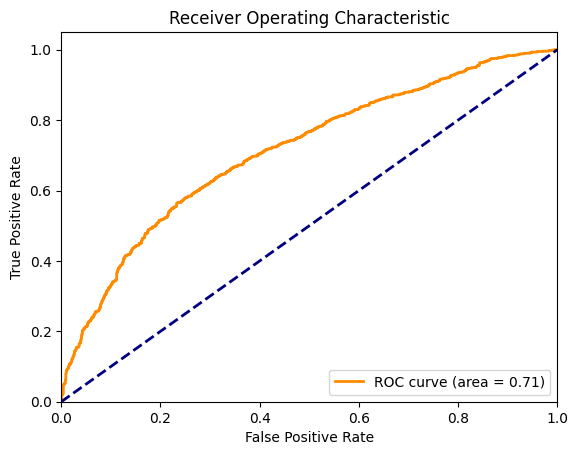

Best Threshold: -2.0052
Accuracy: 0.6654
MCC: 0.3380


In [ ]:
import torch
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef
from tqdm import tqdm


def compute_distances(model, dataloader, device):
    model.eval()
    distances = []
    labels = []  

    with torch.no_grad():
        for anchor, positive, negative in tqdm(dataloader, desc="Computing distances"):
            anchor, positive, negative = anchor.to(
                device), positive.to(device), negative.to(device)

            
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            
            pos_distance = torch.nn.functional.pairwise_distance(
                anchor_out, positive_out)
            neg_distance = torch.nn.functional.pairwise_distance(
                anchor_out, negative_out)

            distances.extend(pos_distance.cpu().numpy())
            distances.extend(neg_distance.cpu().numpy())
            labels.extend([1] * len(pos_distance))
            labels.extend([0] * len(neg_distance))

    return np.array(distances), np.array(labels)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_size = 58
d_model = 64  
nhead = 2
dim_feedforward = 128
dropout = 0.1132929562885964
num_layers = 4


loaded_model = EmbeddingNet(
    input_size, d_model, nhead, dim_feedforward, dropout, num_layers).to(device)



current_dir = os.getcwd()


testing_csv_paths = [
    os.path.join(
        current_dir, r"C:\Users\S\Desktop\VerifyMe\Home\10_3_RFinal-Triplets_Test.csv"),
    
    
]


val_dataset = TripletDataset(testing_csv_paths)


batch_size = 1
num_val = int(len(val_dataset))

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



checkpoint_path = os.path.join(os.getcwd(), 'Q1model_epoch_9.pth')
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    
    print("Checkpoint loaded successfully!")
    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Training Loss: {checkpoint.get('train_loss', 'Not available')}")
    print(f"Validation Loss: {checkpoint.get('val_loss', 'Not available')}")
else:
    print("Checkpoint path does not exist. Please check the file path.")


loaded_model.eval()


distances, labels = compute_distances(loaded_model, val_dataloader, device)



fpr, tpr, thresholds = roc_curve(labels, -distances)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f'Best Threshold: {best_threshold:.4f}')


predictions = (-distances > best_threshold).astype(int)


accuracy = accuracy_score(labels, predictions)
print(f'Accuracy: {accuracy:.4f}')


mcc = matthews_corrcoef(labels, predictions)
print(f'MCC: {mcc:.4f}')

In [5]:
it just memorised the training data

SyntaxError: invalid syntax (447288355.py, line 1)

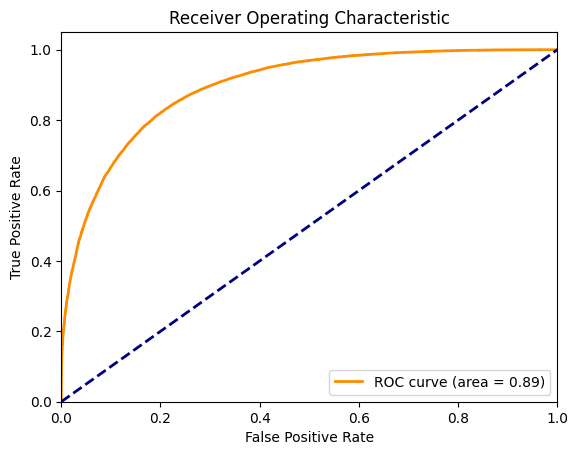
Best Threshold: -3.8865
Accuracy: 0.8106
MCC: 0.6217
epoch 0

After training and evaluating on both 10_3_r and 20_3_r
Cool epoch 1: 'T5model_epoch_2.pth' (loaded with 2 heads instead of the 16 it was trained on)

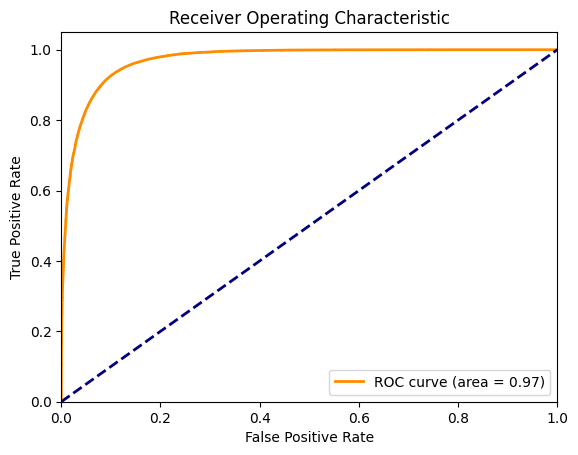
Best Threshold: -4.5656
Accuracy: 0.9132
MCC: 0.8273

^vtl=20
When tested on VTL 10:
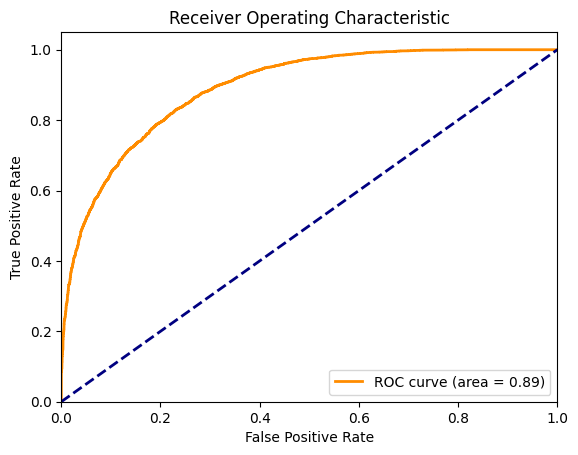
Best Threshold: -4.6036
Accuracy: 0.7993
MCC: 0.5996

when tested on BAWE 10_3

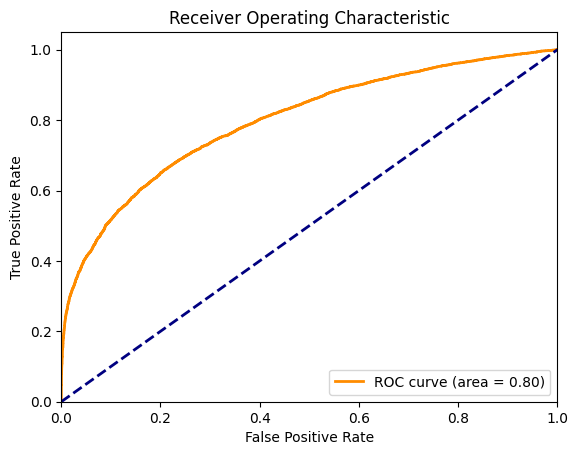
Best Threshold: -3.6739
Accuracy: 0.7253
MCC: 0.4549


I sam silly


Reuters 10_3

'rmodel_epoch_2.pth'



input_size = 58
d_model = 64
nhead = 16
num_layers = 2
dim_feedforward = 128
dropout = 0.1132929562885964
lr = 0.0008091543787569755

Deployment alteration
nhead = 2

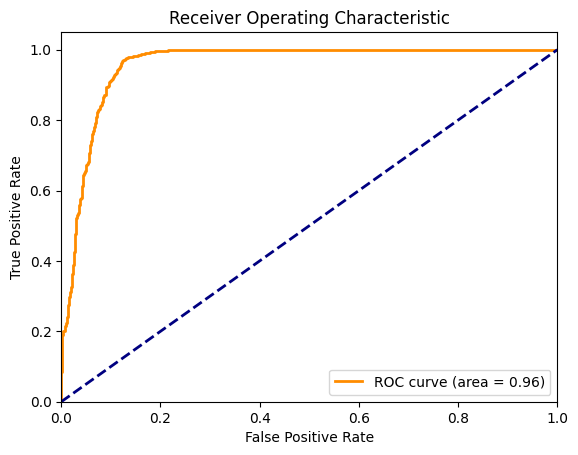

Best Threshold: -5.5281
Accuracy: 0.9221
MCC: 0.8485


Training and testing on 10_1, 50:50 split didn't go well \_\_\_\_. This is interesting and contrary to my findings with the other model.

Does this scale with compute!


Basic BAWE Training - context 3, VTL 10


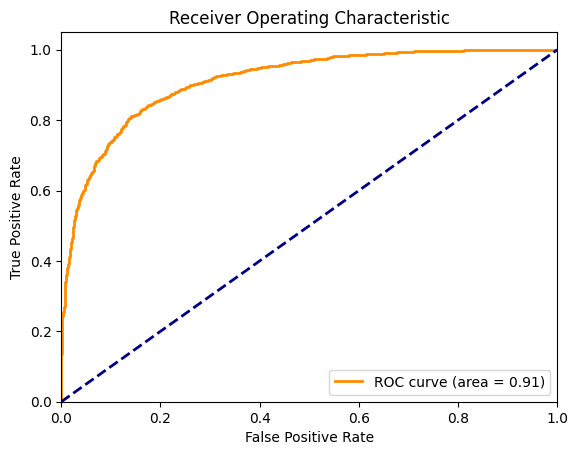

Best Threshold: -6.2003
Accuracy: 0.8346
MCC: 0.6699

Checkpoint loaded successfully!
Epoch: 2 DDDDD
Training Loss: 0.05044650102688654
Validation Loss: 0.3663283266565379



input_size = 58
d_model = 64
nhead = 16
num_layers = 2
dim_feedforward = 128
dropout = 0.1132929562885964
lr = 0.0008091543787569755



model = EmbeddingNet(input_size, d_model, nhead,
dim_feedforward, dropout, num_layers).to(device)
criterion = nn.TripletMarginLoss(margin=1, p=2)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

'dmodel_epoch_3.pth'

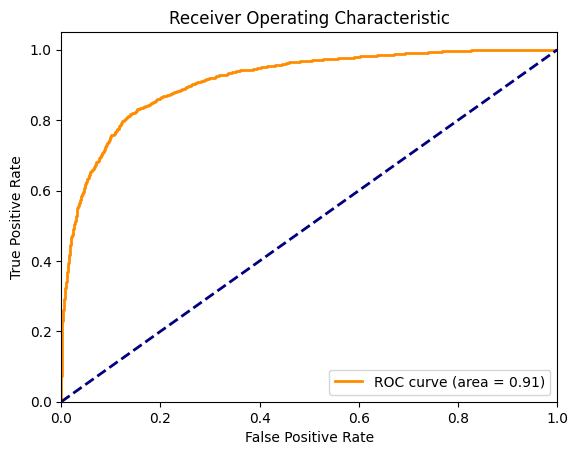



input_size = 58
d_model = 64 
nhead = 2
dim_feedforward = 128
dropout = 0.1132929562885964
num_layers = 2

Best Threshold: -6.9323
Accuracy: 0.8387
MCC: 0.6776

Tested on 10_1
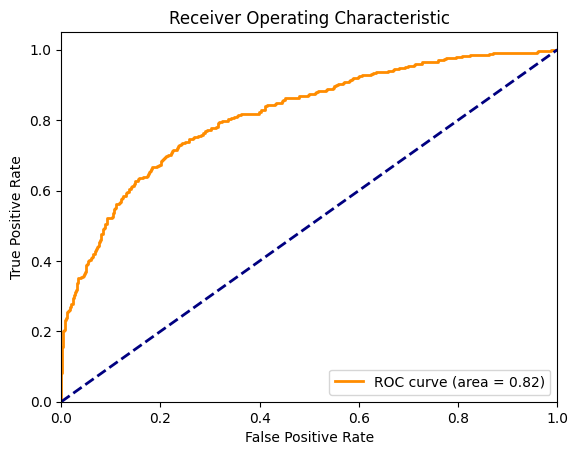 Best Threshold: -7.5517
Accuracy: 0.7451
MCC: 0.4905


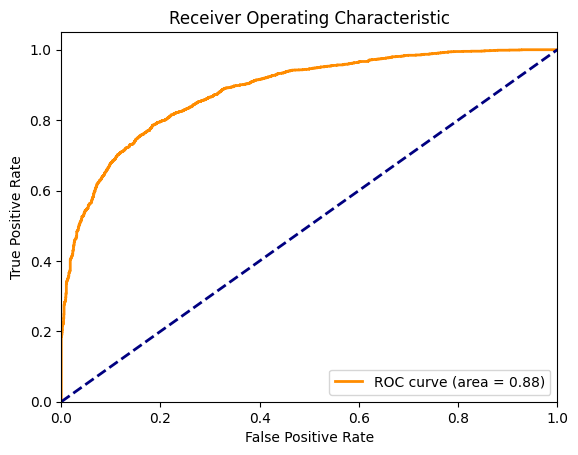

Best Threshold: -6.3898
Accuracy: 0.8002
MCC: 0.6008

Checkpoint loaded successfully!
CEpoch: 2
Training Loss: 0.12821431651812149
Validation Loss: 0.35706005486495357
